# Image Classification with Partition Explainer

### Loading Libraries

In [1]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# SHAP
import shap

# Tabulate
from tabulate import tabulate

# Java Script Object Notation
import json

# OS & Path
import os
import requests
import urllib.request

# TensorFlow
import cv2
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

/opt/anaconda3/envs/ml-explain/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
print(tf.__version__)

print(requests.__version__)

print(cv2.__version__)

2.15.0
2.32.3
4.11.0


#### Placing Model

In [3]:
model = ResNet50(weights='imagenet')

X, y = shap.datasets.imagenet50()

2025-05-23 08:29:07.658204: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-05-23 08:29:07.658243: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-05-23 08:29:07.658250: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-05-23 08:29:07.658286: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-23 08:29:07.658304: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Placing Path

In [4]:
json_file_path = 'imagenet_class_index.json'

# Verifying JSON file
if os.path.exists(json_file_path):
    with open(json_file_path) as file:
        class_names = [v[1] for v in json.load(file).values()]
else:
    url = 'https://s3.amazonaws.com/deep-learning-models/' + \
        'image-models/imagenet_class_index.json'
    with urllib.request.urlopen(url) as response:
        json_data = response.read().decode()
    with open(json_file_path, 'w') as file:
        file.write(json_data)
    class_names = [v[1] for v in json.loads(json_data).values()]

### Applying SHAP for Image Classification

In [5]:
# Model Wrapper
def predict(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

In [6]:
# Masker
masker = shap.maskers.Image(
    'blur(128, 128)', shape = X[0].shape
)

In [7]:
topk = 3

index = [21, 28]

In [8]:
explainer = shap.Explainer(
    predict, masker, output_names=class_names
)

In [9]:
shap_values = explainer(
    X[index], max_evals=1000,
    batch_size=50,
    outputs=shap.Explanation.argsort.flip[:topk],
    silent=True
)

### The Impact of Various Maskers

In [10]:
# Image Masker
mask_names = ['inpaint_telea', 'inpaint_ns',
              'blur(128, 128)', 'blur(16, 16)']

sh = X[0].shape
masks = [shap.maskers.Image(m, sh) for m in mask_names]

In [11]:
# Array
arr = np.zeros((224 * 224 * 3), dtype=bool)

# Upper Half Set-Up
arr[:75264] = True

# Lower Half
arr[75264:] = False

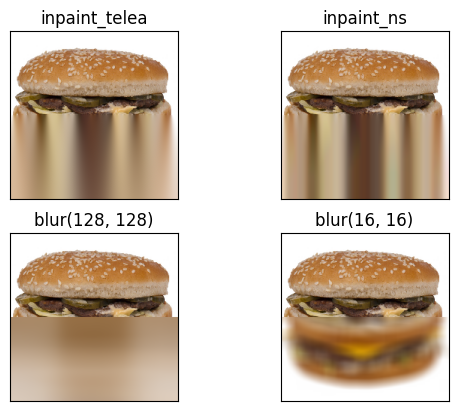

In [12]:
fig, axs = plt.subplots(2, 2)
ind = 0

for i in [0, 1]:
    for j in [0, 1]:
        axs[i, j].imshow(masks[ind](x=X[21], mask=arr)[0][0] / 255)
        axs[i, j].set_title(mask_names[ind])
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].tick_params(axis='both', which='both', length=0)
        ind += 1

plt.show()

inpaint_telea


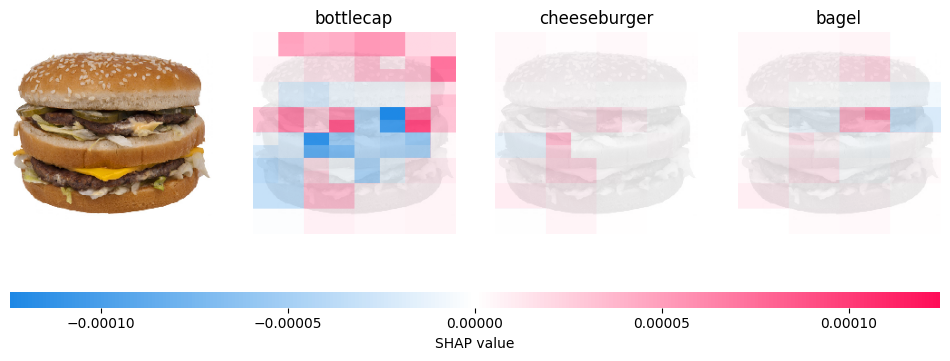

inpaint_ns


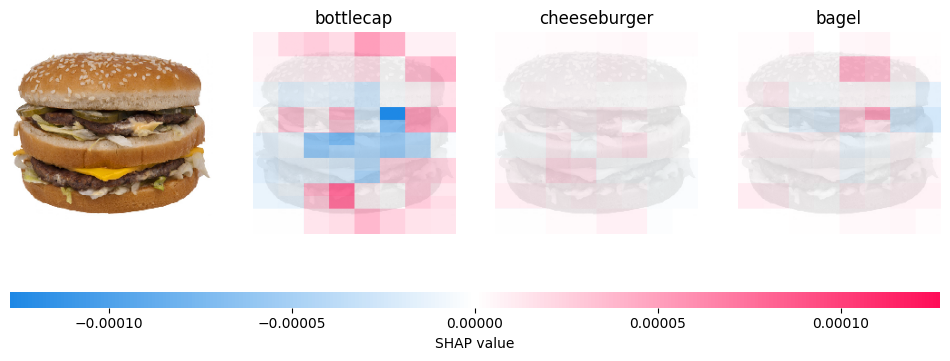

blur(128, 128)


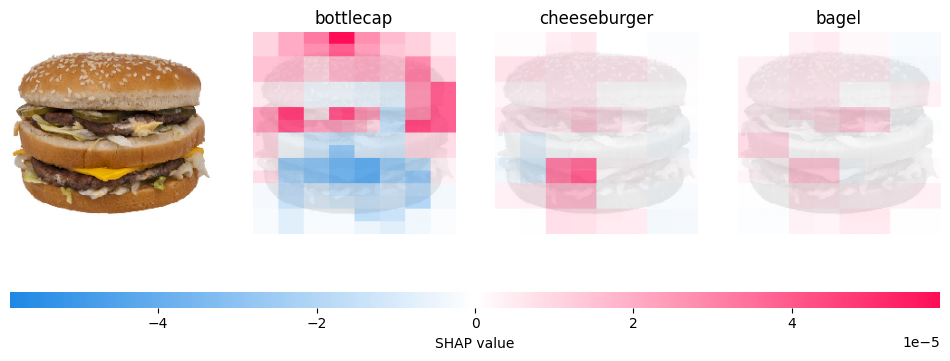

blur(16, 16)


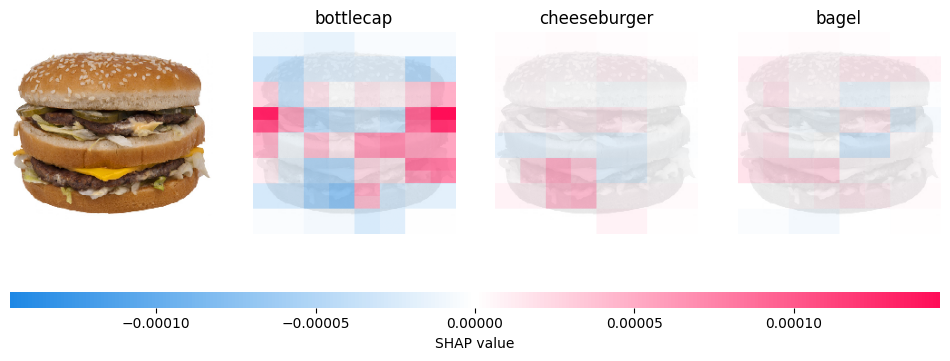

In [16]:
topk = 3

# Iterating Through Masks
for mask_name in mask_names:
    print(mask_name)
    mask = shap.maskers.Image(mask_name, shape=sh)
    explainer = shap.Explainer(
        predict,
        mask,
        output_names=class_names, 
        silent=True
    )
    shap_values = explainer(
        X[[21]], max_evals=500, batch_size=50,
        outputs=shap.Explanation.argsort.flip[:topk]
    )
    shap.image_plot(shap_values, pixel_values=X[[21]] / 255)

### Effect of Increasing The Evaluation Steps

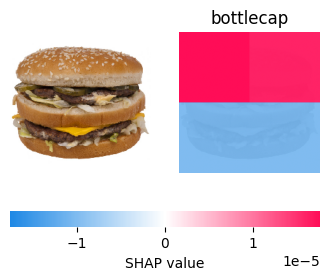

In [19]:
topk = 1

masker = shap.maskers.Image(
    'blur(128, 128)', shape=sh
)

explainer = shap.Explainer(predict, masker, output_names=class_names)
shap_values = explainer(
    X[[21]],
    max_evals=10,
    batch_size=50,
    outputs=shap.Explanation.argsort.flip[:topk]
)

shap.image_plot(shap_values, pixel_values=X[[21]]/255, width=4)

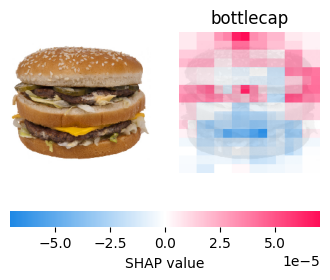

In [20]:
# On Over 1000 Evaluation

# topk = 1

# masker = shap.maskers.Image(
#     'blur(128, 128)', shape=sh
# )

explainer = shap.Explainer(predict, masker, output_names=class_names)

shap_values = explainer(
    X[[21]],
    max_evals=1000,
    batch_size=50,
    outputs=shap.Explanation.argsort.flip[:topk]
)

shap.image_plot(shap_values, pixel_values=X[[21]]/255, width=4)